# Tensorflow course
## Convolutional Neural Net Example
Using tensorflow build a convolutional neural net to classify the mnist dataset.

## Convolutional net
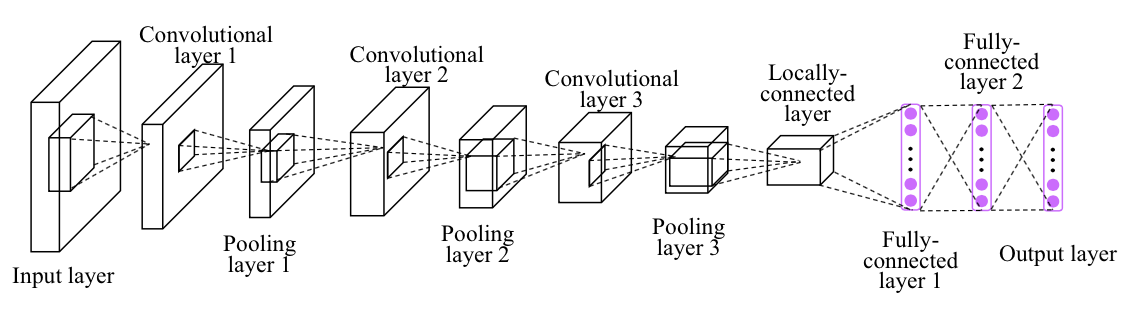

## MNIST Dataset
This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flatten and converted to a 1-D numpy array of 784 features (28*28).

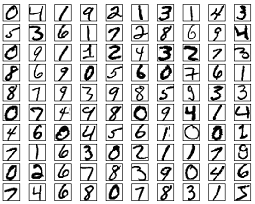

In [1]:
# We import the modules needed.
import sys, os, datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import utils.utils as utils

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
# Reshape to image for visualization
train_data = mnist.train.images
train_label = mnist.train.labels
test_data = mnist.test.images
test_label = mnist.test.labels

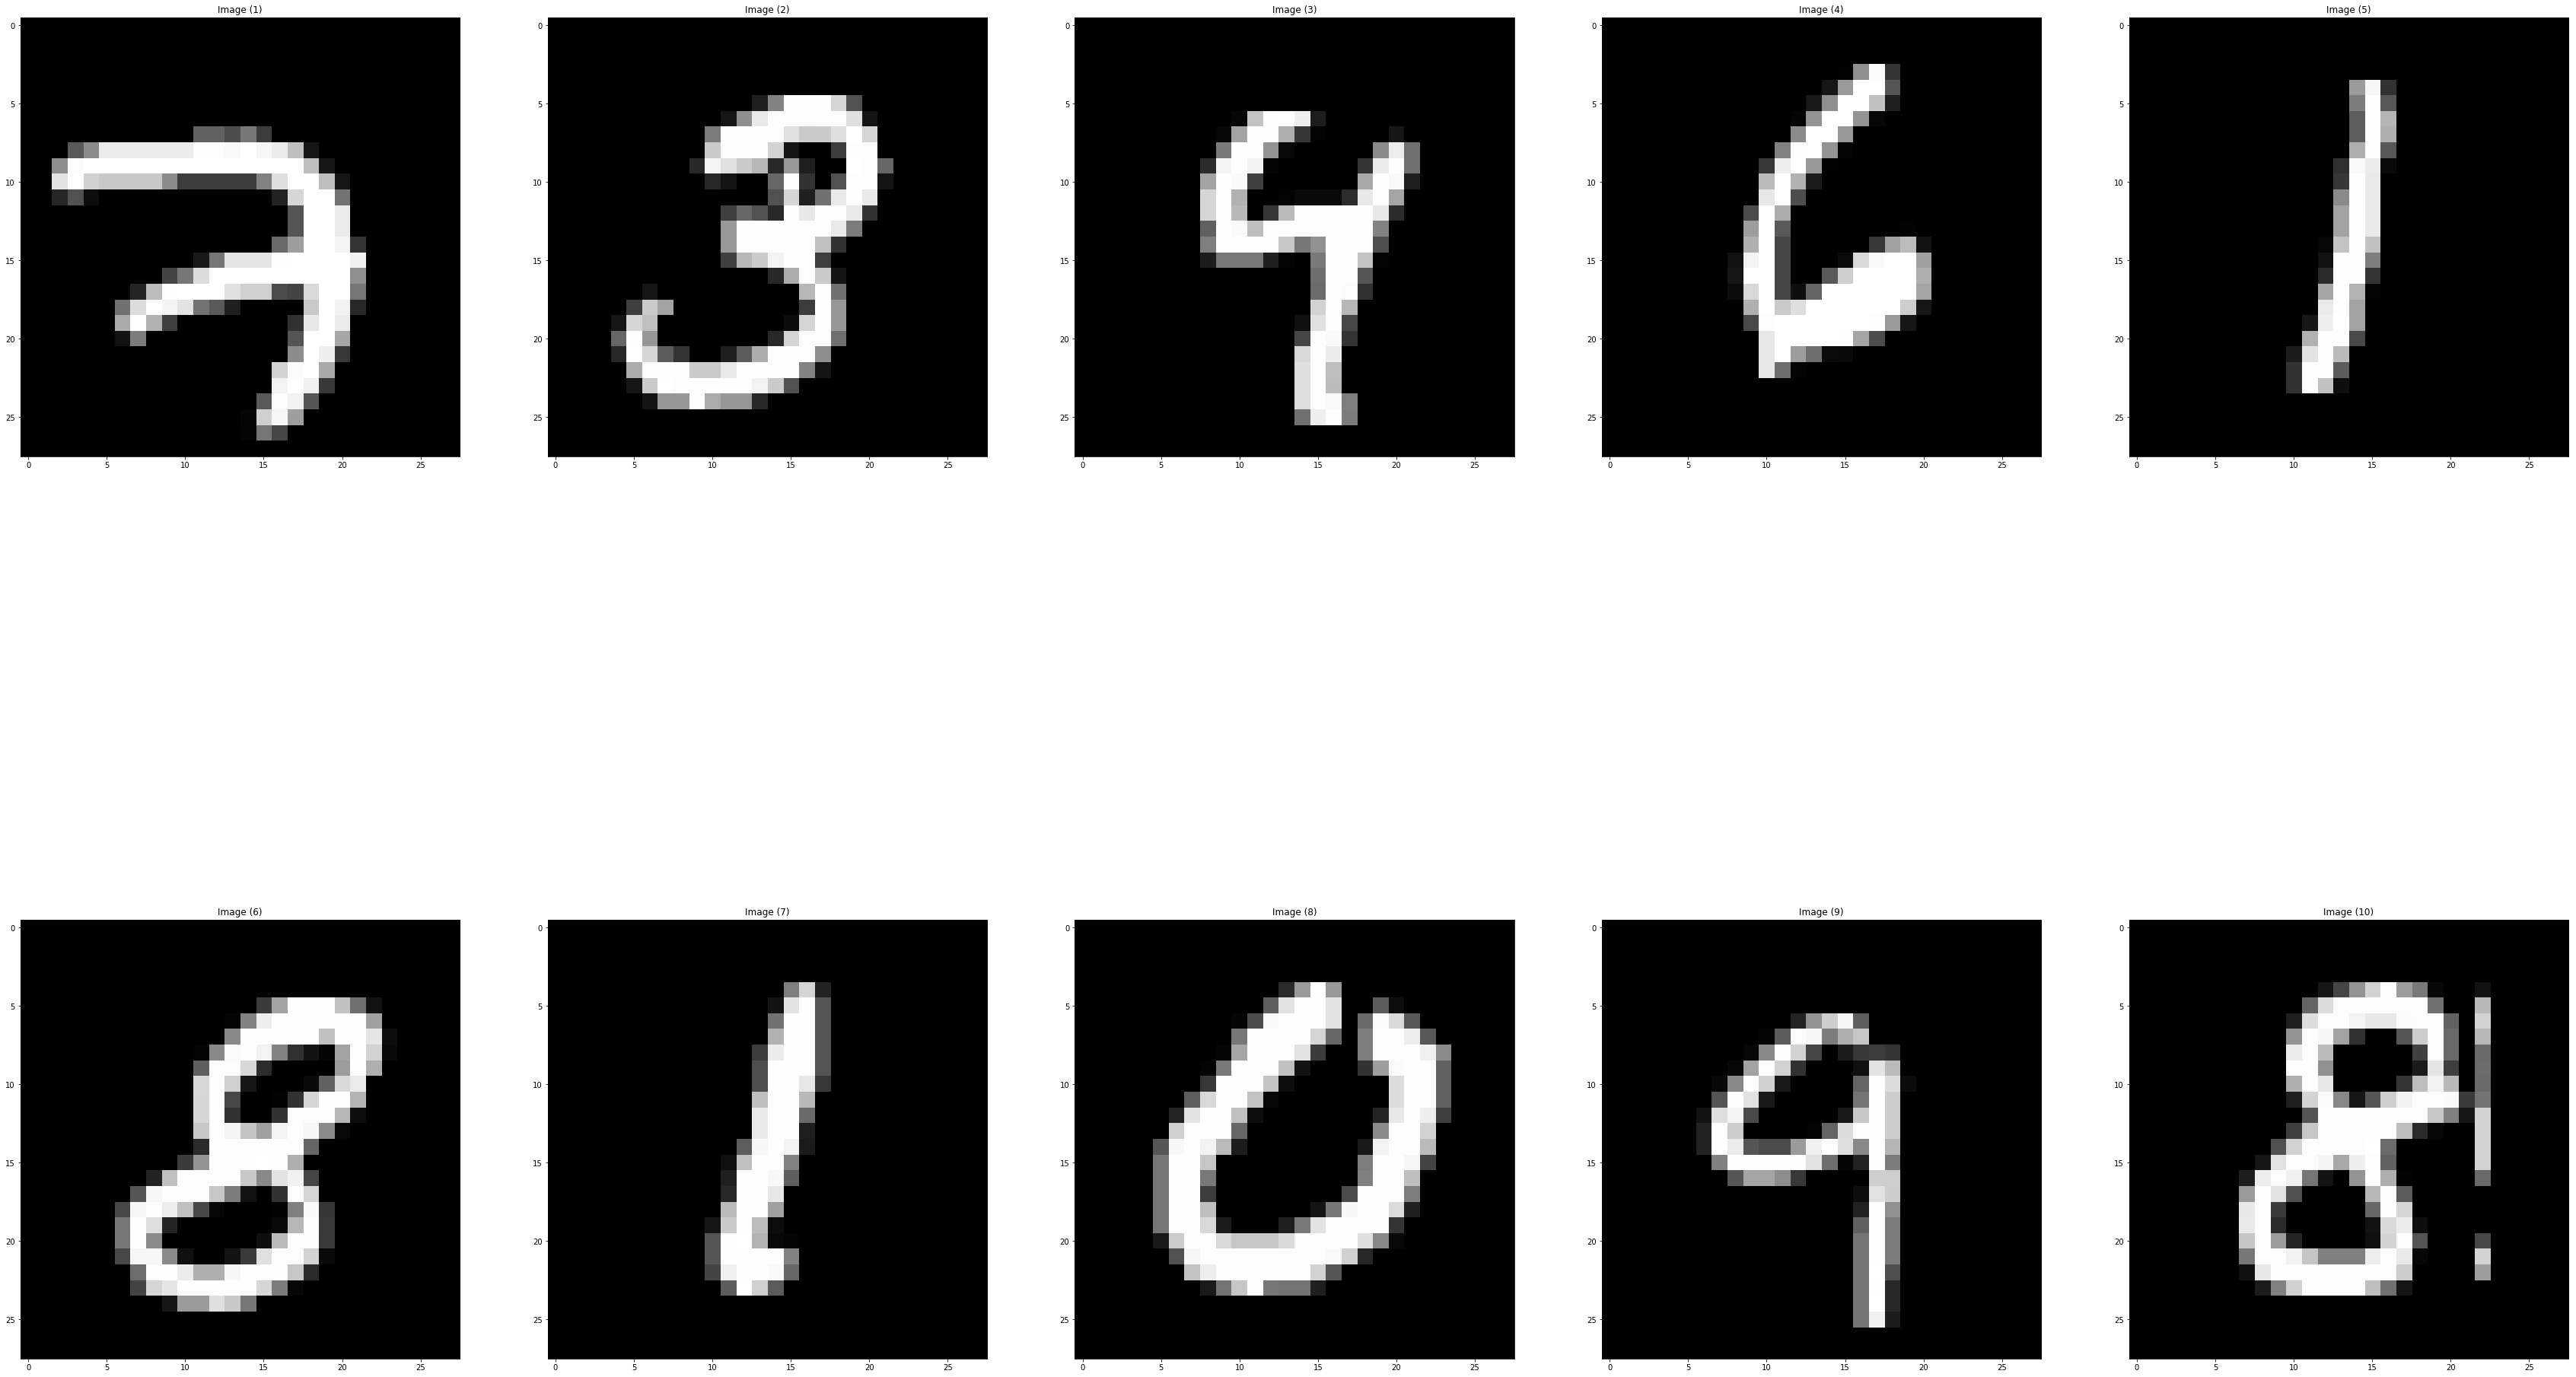

In [4]:
# Show input images
show_data = np.reshape(train_data,(-1, 28, 28))
utils.show_images(show_data[0:10], 2)

In [5]:
train_dataSet = utils.DataSet(train_data, train_label)
test_dataSet = utils.DataSet(test_data, test_label)

In [6]:
# Parameters for the neural net
# step size for gradient decsent
learning_rate = 0.005
#Iterations of forward and back pass
training_iters = 2**20

#size of each batch used for forward/backwards pass
batch_size = 2**8

# how often we write to console and to tensorboard the tensorboard
display_step = 64

# Network Parameters
#size of the kernel the local region that is slid along the convolution
kernel = 5

#amount of output classes
n_classes = 10

# Dropout to reguralize and ensure we dont overfit.
# it basically disables some random nodes each forward/backwards pass
# to enforce new paths to be discovered in the net. Not used in testing.
dropout = 0.50 # Dropout, probability to keep units

# tf Graph input
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, 28 * 28])
    y = tf.placeholder(tf.int64, None)
    keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)


In [7]:
# Create layer weights & bias
with tf.name_scope('Weights'):
    weights = {
         # Weights for 1st conv 
        'wc1': tf.Variable(tf.truncated_normal([kernel, kernel, 1, 32])),
        'wc2': tf.Variable(tf.truncated_normal([kernel, kernel, 32, 64])),

        # Weights for Fully connected
        # 28x28-> 7x7 after 2x maxpool(2,2) times the amount of filters
        'wf1': tf.Variable(tf.truncated_normal([7 * 7 * 64, 1024])), 
        'out': tf.Variable(tf.truncated_normal([1024, n_classes]))
    }
with tf.name_scope('Biases'):
    biases = {
        # Bias for 1st conv block
        'bc1': tf.Variable(tf.truncated_normal([32])),
        'bc2': tf.Variable(tf.truncated_normal([64])),

        # Bias for Fully connected
        'bf1': tf.Variable(tf.truncated_normal([1024])),
        # Bias for Output
        'out': tf.Variable(tf.truncated_normal([n_classes]))
    }

In [8]:
# Create model using tflayers
# the model is identical
def conv_net(x, weights, biases, dropout, reuse, is_training = False):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet/', reuse = reuse):
        x = tf.reshape(x, shape=[-1, 28, 28, 1])
        # 1st conv-layer block
        conv_1 = tf.layers.conv2d(x, 32, 5, activation = tf.nn.relu)
        pool_1 = tf.layers.max_pooling2d(conv_1, 2, 2)

        # 2nd conv-layer block
        conv_2 = tf.layers.conv2d(pool_1, 64, 5, activation = tf.nn.relu)
        pool_2 = tf.layers.max_pooling2d(conv_2, 2, 2)

        # Fully connected layer
        fc_1 = tf.contrib.layers.flatten(pool_2)
        fc_1 = tf.layers.dense(fc_1, 1024)
        fc_1 = tf.layers.dropout(fc_1, rate = dropout, training = is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc_1, n_classes)
    return out

In [9]:
# Construct models
# Training graph
train_prediction = conv_net(x, weights, biases, keep_prob, 
                            reuse=False, is_training = True)

# Testing graph reuses weights learned in train
test_prediction = conv_net(x,  weights, biases, keep_prob, 
                           reuse=True, is_training = False)

In [10]:
# Define loss and optimizer
with tf.name_scope('loss'):
    #calculate the crossentropy for each sample in batch
    x_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits = train_prediction, 
        labels = y)
    #find mean loss of batch
    loss_op = tf.reduce_mean(x_entropy)

with tf.name_scope('optimizer'):
    # define what optimizer to use SGD in this case
    #optimizer = tf.train.AdagradOptimizer(learning_rate = learning_rate)
    #optimizer = tf.train.RMSPropOptimizer(learning_rate = learning_rate)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    # tell the optimizer to minimize the loss
    minimize_op = optimizer.minimize(loss_op)


# Evaluate model with test graph
with tf.name_scope('Accurracy'):
    predictions = tf.argmax(test_prediction, 1)
    correct_pred = tf.equal(predictions, y)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    tf.summary.scalar("Test_Accuracy", accuracy)


# add scalars to Tensorboard
merged_summaries = tf.summary.merge_all()
tf.summary.scalar("Training_X_entropy", loss_op)
# Initializing the variables
init = tf.global_variables_initializer()

In [11]:
# Name for tensorboard.
name = 'tb_'+ str(datetime.datetime.now().strftime('%Y-%m-%d_%H%M_%S'))
cwd = os.getcwd()
tb_path = os.path.join(cwd, "Tensorboard")
tb_path = os.path.join(tb_path, name)

# Launch the graph
sess=tf.InteractiveSession()
# initialize graph variables
sess.run(init)
# create the summary file for tensorboard
writer = tf.summary.FileWriter(tb_path, sess.graph)

# define a list of the variables we want the graph to return
outputs = [accuracy, merged_summaries]

step = 1
# Keep training until max iterations is reached
while step * batch_size < training_iters:
    # load first batch
    batch_x, batch_y = train_dataSet.next_batch(batch_size)
    
    # feed dict is what we are giving the graph these are placed in the
    # placeholders we defined earlier
    feed_dict = {x: batch_x, y: batch_y, keep_prob: dropout}
    
    # this is the training call to backpropagate.
    # If the minimize is added the network first does a forward pass
    # and then a backwards pass attempting to minimize the loss
    _, loss = sess.run([minimize_op, loss_op], feed_dict)
    
    # Testing step see if data is converging
    if step % display_step == 0:
        # To devleoper show loss accuracy and save values to tensorboard
        # this runs a forward pass and compares the output with the label
        # and stores the accuracy and loss in the tensorboard.
        
        # No dropout in testing so keep prob = 1
        feed_dict = {x: batch_x, y: batch_y, keep_prob: 1.}
        
        # forward pass
        acc, summary = sess.run(outputs, feed_dict)
        # print Loss and accuracy
        pvalue = "Iter {0}, Minibatch Loss= {1:.4f}, Training Accuracy= {2:.3f}"
        print(pvalue.format(str(step * batch_size), loss, acc), end='\r')
        # write to tensorboard
        writer.add_summary(summary, step)
        
    # update step
    step += 1
    
print("\nOptimization Finished!, Training Accuracy= {:.3f}".format(acc))



Iter 1032192, Minibatch Loss= 0.0399, Training Accuracy= 0.996
Optimization Finished!, Training Accuracy= 0.996


In [12]:
# Inference
# Test on the test dataset to see how good our network is]
# append accuracies from each batch
acc_app=[]
for i in range(10):
    batch_x, batch_y = test_dataSet.next_batch(1056)
    feed_dict={x: batch_x, y: batch_y, keep_prob: 1.}
    # Forward pass and return accuracy and predictions
    acc, cp = sess.run([accuracy, predictions], feed_dict)
    acc_app.append(acc)
mean = np.mean(np.array(acc_app))
print("Accuracy for the testing dataset is: {0:.4f}".format(mean))

Accuracy for the testing dataset is: 0.9812


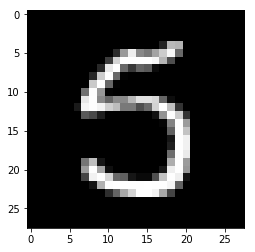

In [13]:
# select a random sample in the test data
rnd = np.random.randint(len(test_dataSet.data)-1)
image = test_dataSet.data[rnd]
label = test_dataSet.label[rnd]
show = np.reshape(image,(28,28))
plt.imshow(show, cmap='gray')
plt.show()

In [14]:
# expand dimensions of image to have get right dimensions
# basically saying the input has a batch size of 1
exp_img = np.expand_dims(image, 0)
feed_dict={x: exp_img, y: label, keep_prob: 1.}
acc, pred = sess.run([accuracy, predictions], feed_dict)

print("Prediction: {0} \nLabel: {1} \nis equal? {2}".format(pred[0], label, pred[0] == label))

Prediction: 5 
Label: 5 
is equal? True


In [15]:
# Create some wrappers for simplicity

def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


In [16]:
# Create model using wrappers
# the model is identical
def conv_net_wrappers(x, weights, biases, dropout, name, reuse, is_training = False):
    with tf.variable_scope(name+"_ConvNet", reuse=reuse):
        x = tf.reshape(x, [-1, 28, 28, 1]) # bwhc
        
        # 1st conv-layer block
        conv_1 = conv2d(x, weights['wc1'], biases['bc1'])
        # 1st pool layer
        pool_1 = maxpool2d(conv_1, 2) 
        
        # 2nd conv-layer block
        conv_2= conv2d(pool_1, weights['wc2'], biases['bc2'])
        # 2nd pool layer
        pool_2 = maxpool2d(conv_2, 2)
        
        # Fully connected layer
        fc_1 = tf.reshape(pool_2, [-1, weights['wf1'].get_shape().as_list()[0]])
        fc_1 = tf.matmul(fc_1fc_1, weights['wf1']) + biases['bf1']
        fc_1 = tf.nn.relu(fc_1)
        # Apply Dropout
        drop = tf.nn.dropout(fc_1, dropout)
        # Output, class prediction
        out = tf.matmul(drop, weights['out']) + biases['out']
    return out

In [17]:
# Create model using tflayers
# the model is identical
def conv_net_tflayers(x, dropout, name, reuse, is_training = False):
    
    # Define a scope for reusing the variables
    with tf.variable_scope(name +'_ConvNet', reuse=reuse):
        x = tf.reshape(x, shape=[-1, 28, 28, 1])
        
        with tf.variable_scope(name + "_conv_block1")
            # 1st conv-layer block
            conv_1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
            pool_1 = tf.layers.max_pooling2d(conv_1, 2, 2)
        
        with tf.variable_scope(name + "_conv_block2")
            # 2nd conv-layer block
            conv_2 = tf.layers.conv2d(pool_1, 64, 3, activation=tf.nn.relu)
            pool_2 = tf.layers.max_pooling2d(conv2, 2, 2)
        
        with tf.variable_scope(name + "_fully_connected")
            # Fully connected layer
            fc_1 = tf.contrib.layers.flatten(pool_2)
            fc_1 = tf.layers.dense(fc_1, 1024)
            fc_1 = tf.layers.dropout(fc_1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

SyntaxError: invalid syntax (<ipython-input-17-eef92e81fa08>, line 9)

In [ ]:
# Create model
def conv_net(x, weights, biases, dropout, name, reuse, is_training = False):
    with tf.variable_scope(name + "_ConvNet", reuse=reuse):
        # reshape input from vector to [batch, width, height, channels]
        x = tf.reshape(x, [-1, 28, 28, 1]) # bwhc
        
        # 1st conv-layer block
        with tf.variable_scope(name+"_conv_block1"):
            conv_1 = tf.nn.conv2d(x, weights['wc1'], strides=[1, 1, 1, 1], padding='SAME')
            conv_1 = conv_1 + biases['bc1']
            conv_1 = tf.nn.relu(conv_1)
            # 1st pool layer
            pool_1 = tf.nn.max_pool(conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                          padding='SAME')
        
        # 2nd conv-layer block
        with tf.variable_scope(name + "_conv_block2"):
            conv_2 = tf.nn.conv2d(pool_1, weights['wc2'], strides=[1, 1, 1, 1], padding='SAME')
            conv_2 = conv_2 + biases['bc2']
            conv_2 = tf.nn.relu(conv_2)

            # 2nd pool layer
            pool_2 = tf.nn.max_pool(conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                              padding='SAME')
        

        with tf.variable_scope(name + "_fcn_1"):
            # Fully connected 1'
            # flatten the convolutional output to a vector
            fc_1 = tf.reshape(pool_2, [-1, weights['wf1'].get_shape().as_list()[0]])
            # matrix multiplication with weights and add bias
            fc_1 = tf.matmul(fc_1, weights['wf1']) + biases['bf1']
            fc_1 = tf.nn.relu(fc_1)
        # Apply Dropout
        drop = tf.nn.dropout(fc_1, dropout) 
        
        # Output, class prediction
        out = tf.matmul(drop, weights['out']) + biases['out']

    return out